In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D,Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.applications import VGG19
import cv2
import os
import random
import tensorflow as tf
import numpy as np

2023-05-23 23:38:39.990941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model 2: VGG19

In [2]:
#pip install opencv-python

### Prepare the data

In [2]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
#img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
data = get_data("/Users/lulu/Desktop/uchicago/msca 31009/flowers")

/var/folders/gq/ppw9_tc15qg2j8hl1jwdxg880000gp/T/ipykernel_13312/2726535806.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [4]:
data.shape

(4317, 2)

In [4]:
data

array([[array([[[18, 27, 29],
                [ 7, 18, 19],
                [47, 58, 62],
                ...,
                [17, 22, 25],
                [ 7,  9, 10],
                [13, 10,  9]],

               [[19, 36, 34],
                [23, 38, 42],
                [37, 55, 55],
                ...,
                [25, 33, 36],
                [ 9, 13, 15],
                [ 9, 10, 10]],

               [[40, 61, 60],
                [34, 56, 52],
                [55, 75, 80],
                ...,
                [18, 27, 30],
                [19, 25, 29],
                [20, 24, 28]],

               ...,

               [[11, 21, 14],
                [13, 25, 17],
                [13, 26, 18],
                ...,
                [ 7, 29, 10],
                [ 7, 29, 10],
                [ 7, 29, 11]],

               [[12, 26, 15],
                [14, 28, 17],
                [13, 27, 16],
                ...,
                [ 8, 29,  7],
                [ 8, 29,  

### EDA

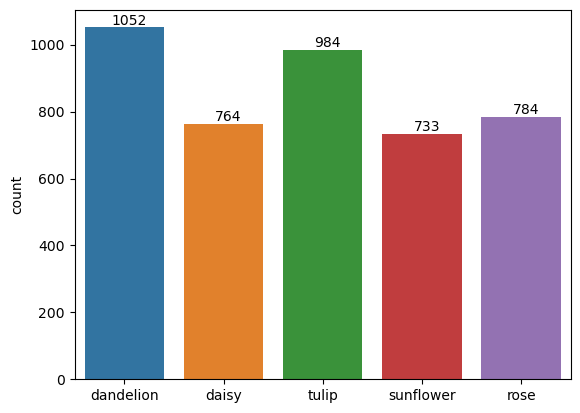

In [7]:
l = []
for i in data:
    l.append(labels[i[1]])
#sns.set_style('dark')
countplot = sns.countplot(x=l)
for p in countplot.patches:
    countplot.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.45, p.get_height()+0.1), ha='center', va='bottom', color= 'black')
plt.show()

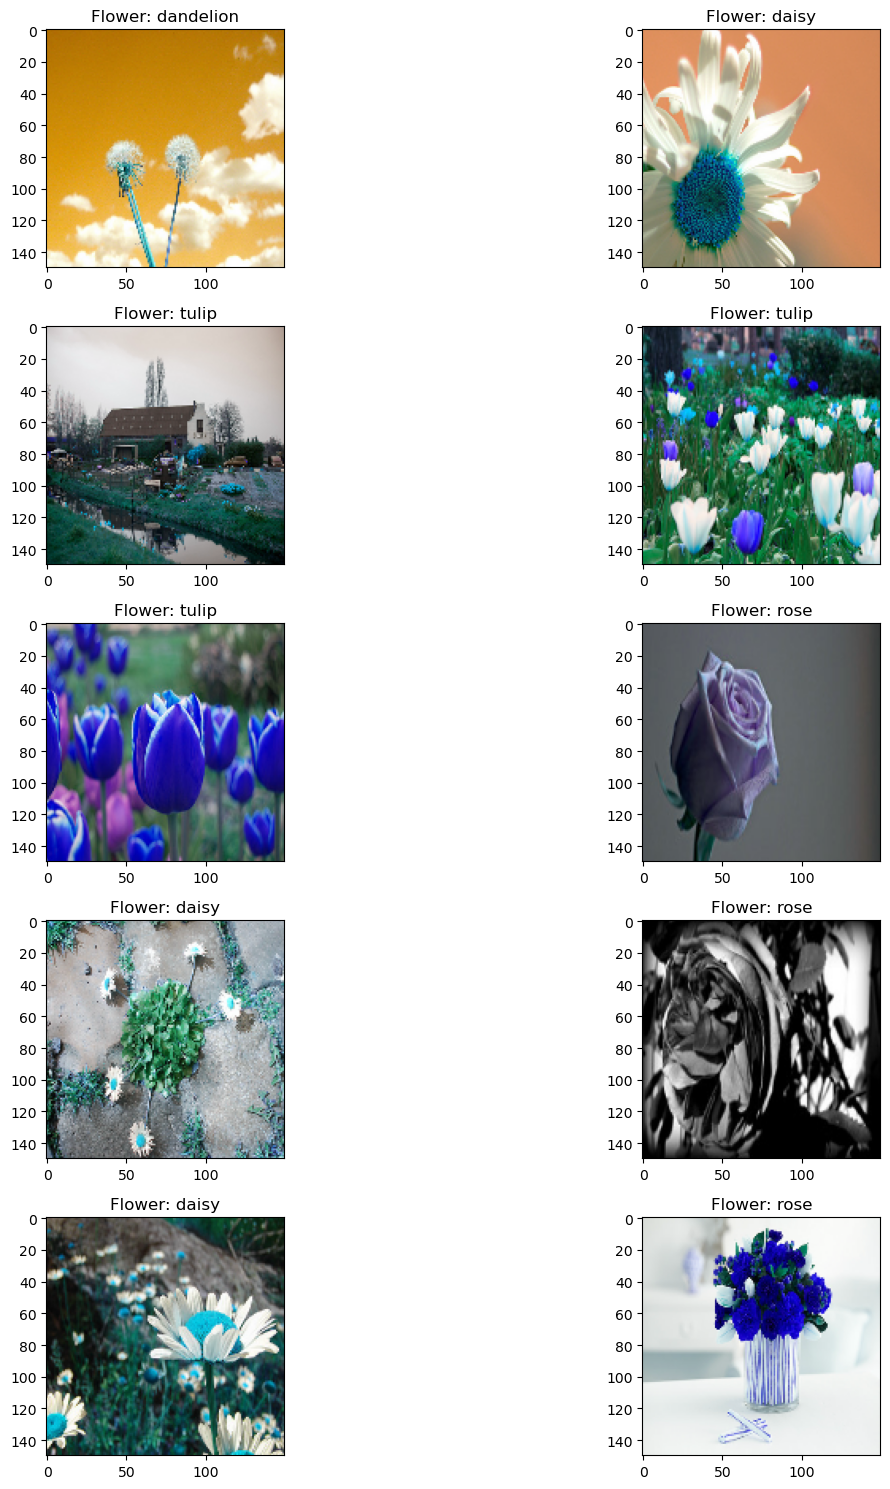

In [8]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

### Feature Engineering and Transformation

In [6]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [7]:
# Normalize the data
x = np.array(x) / 255

In [8]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [9]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

### Train Test Split

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

### Build the model

In [11]:
pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 5)                 23045     
                                                                 
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


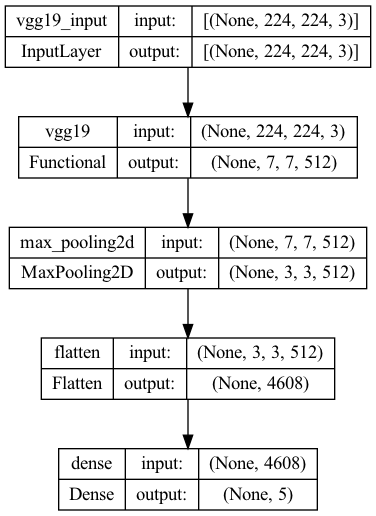

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='vgg_architecture.png', show_shapes=True, show_layer_names=True)

In [13]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

### Train baseline model

In [14]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 10 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])


Epoch 1/10
54/54 [==============================] - 719s 13s/step - loss: 0.9849 - accuracy: 0.6229 - val_loss: 0.5802 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 2/10
54/54 [==============================] - 1051s 20s/step - loss: 0.4652 - accuracy: 0.8251 - val_loss: 0.4812 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 3/10
54/54 [==============================] - 671s 12s/step - loss: 0.3327 - accuracy: 0.8778 - val_loss: 0.4274 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 4/10
54/54 [==============================] - 679s 13s/step - loss: 0.1922 - accuracy: 0.9354 - val_loss: 0.3843 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 5/10
54/54 [==============================] - 936s 17s/step - loss: 0.1134 - accuracy: 0.9621 - val_loss: 0.4299 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 6/10
54/54 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9812 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
54/54 [==============================] - 1089s 20s/st

In [15]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

27/27 [==============================] - 126s 5s/step - loss: 0.5106 - accuracy: 0.8935
Loss of the model is -  0.5105957984924316
27/27 [==============================] - 125s 5s/step - loss: 0.5106 - accuracy: 0.8935
Accuracy of the model is -  89.35185074806213 %


Since the baseline model has better result than the traditional CNN model, I did not tune it due to the limitation of CPU.

### Plot model results

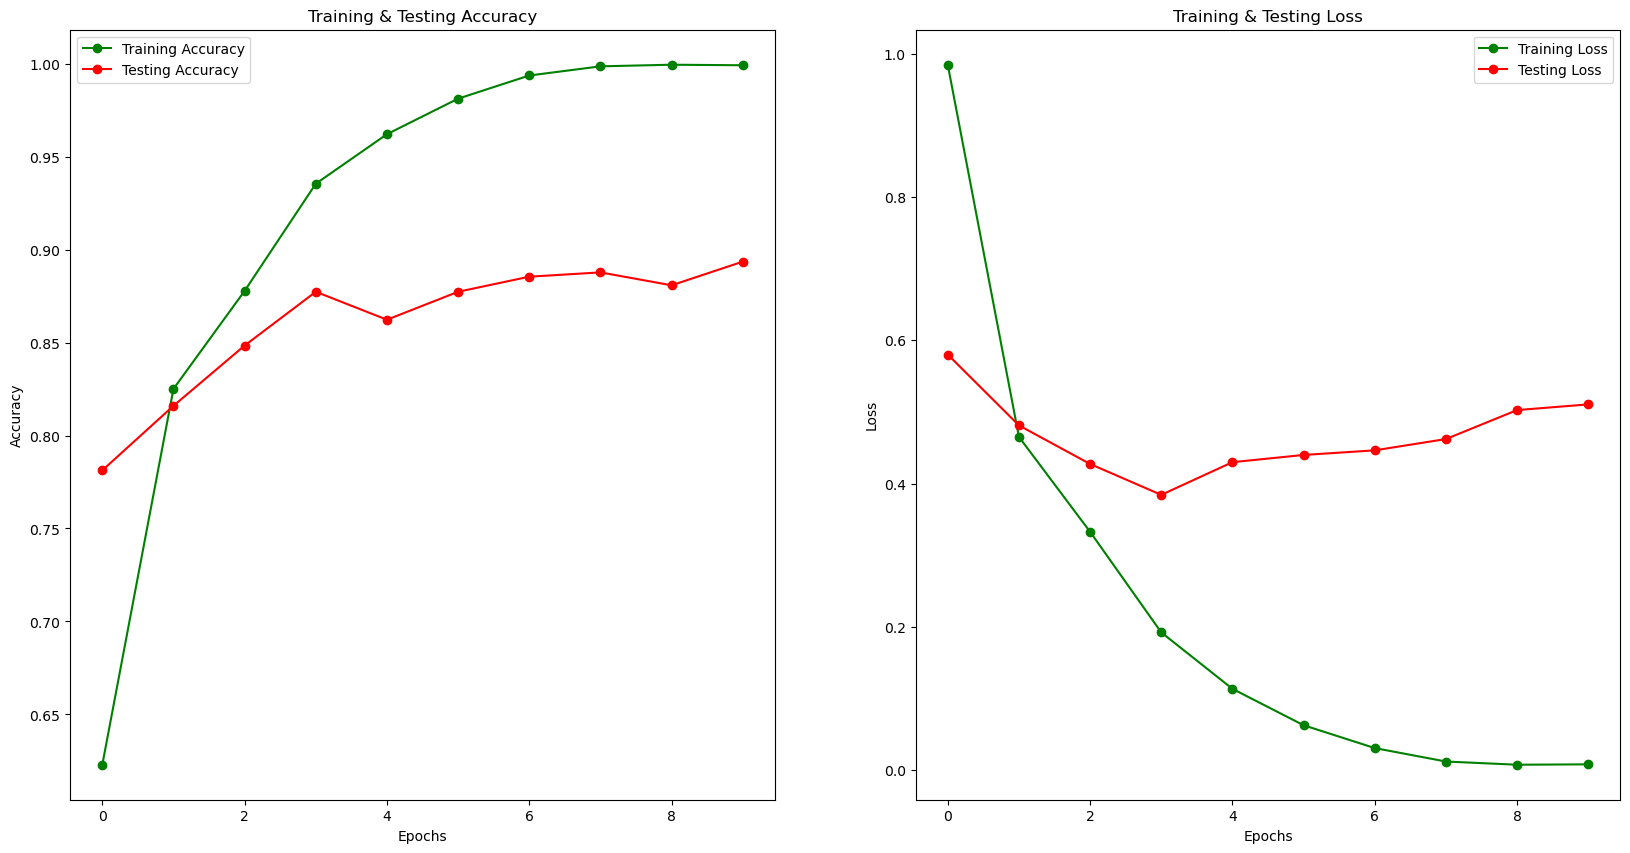

In [16]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [20]:
predictions = model.predict(x_test)
predictions[:5]

27/27 [==============================] - 121s 4s/step


array([[3.3504816e-12, 6.1845806e-12, 9.9999994e-01, 4.4992621e-12,
        3.2423234e-08],
       [3.9952088e-08, 5.2719007e-10, 6.0033813e-07, 1.5655389e-03,
        9.9843383e-01],
       [1.8316302e-02, 1.0088961e-01, 2.1762247e-03, 4.4980130e-05,
        8.7857276e-01],
       [9.1556811e-11, 9.9999994e-01, 6.3798430e-19, 8.2316071e-10,
        8.3398843e-12],
       [3.3489214e-09, 4.2753101e-10, 3.9594474e-11, 9.9999994e-01,
        3.5749718e-13]], dtype=float32)

In [23]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes[:5]

array([2, 4, 4, 1, 3])

In [24]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [25]:
print(classification_report(y_test_inv, predicted_classes, target_names = labels))

              precision    recall  f1-score   support

   dandelion       0.90      0.94      0.92       210
       daisy       0.94      0.88      0.91       153
       tulip       0.92      0.83      0.87       197
   sunflower       0.94      0.89      0.92       147
        rose       0.80      0.94      0.86       157

    accuracy                           0.89       864
   macro avg       0.90      0.89      0.89       864
weighted avg       0.90      0.89      0.89       864



In [27]:
cm_vgg = confusion_matrix(y_test_inv,predicted_classes)
cm_vgg

array([[197,   4,   2,   4,   3],
       [  9, 134,   2,   2,   6],
       [  6,   1, 163,   2,  25],
       [  5,   2,   6, 131,   3],
       [  3,   2,   5,   0, 147]])

In [28]:
import pandas as pd
cm = pd.DataFrame(cm_vgg , index = labels , columns = labels)

<Axes: >

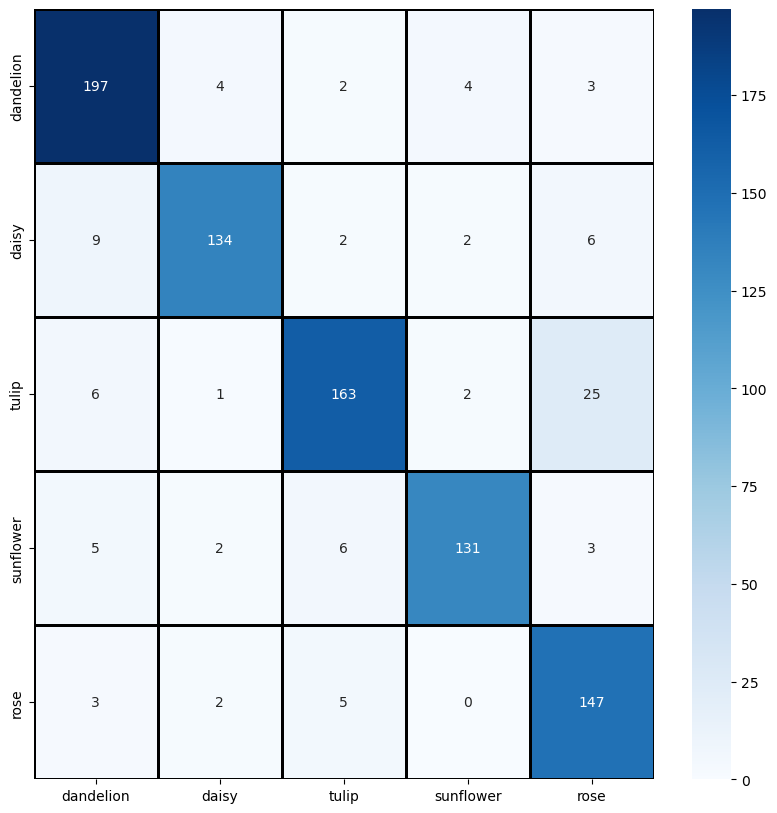

In [29]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)